# Train a shallow SNN on the Randman Dataset

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import wandb

import matplotlib.pyplot as plt
import seaborn as sns

import stork
from stork.datasets import make_coRandman, RasDataset, split_dataset
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, FilterLIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer, DistInitializer

## Generate Dataset

Specify the Dataset Parameters

In [2]:
# dataset parameters
dim_manifold = 1
nb_sub_classes = 5
nb_classes = nb_sub_classes**2
nb_inputs = 20

nb_time_steps = 180
T_delay = 30
sample_duration = 30


nb_samples = 100
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt


# Model Parameters
batch_size = 250
beta = 20
device = torch.device("cpu")
dtype = torch.float


nb_hidden_units = 128
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 40e-3

tau_filter = 20e-3
nb_filters = 10

lr = 5e-3
nb_epochs = 10

rec = False

# regularizer parameters
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Initializer parameters
sigma_u = None
nu = None
gain = 10


# seeds
seed = 346 #235, 346, 457
np.random.seed(seed)
torch.manual_seed(seed)


dt_format = "%Y-%m-%d_%H:%M:%S"

In [3]:
config = {
    "dataset.dim_mainfold": dim_manifold,
    "dataset.nb_sub_classes": nb_sub_classes,
    "dataset.nb_classes": nb_classes,
    "dataset.nb_inputs": nb_inputs,
    "dataset.nb_time_steps": nb_time_steps,
    "dataset.T_delay": T_delay,
    "dataset.sample_duration": sample_duration,
    "dataset.nb_samples": nb_samples,
    "dataset.nb_spikes": nb_spikes,
    "dataset.alpha": alpha,
    "dataset.randmanseed": randmanseed,
    "dataset.dt": dt,
    "dataset.duration": duration,
    "model.batch_size": batch_size,
    "model.beta": beta,
    "model.device": device,
    "model.dtype": dtype,
    "model.nb_hidden_units": nb_hidden_units,
    "model.tau_mem": tau_mem,
    "model.tau_syn": tau_syn,
    "model.tau_readout": tau_readout,
    "model.tau_filter": tau_filter,
    "model.nb_filters": nb_filters,
    "model.lr": lr,
    "model.nb_epochs": nb_epochs,
    "model.rec": rec,
    "regularizer.lowerBoundL2Strength": lowerBoundL2Strength,
    "regularizer.lowerBoundL2Threshold": lowerBoundL2Threshold,
    "regularizer.upperBoundL2Strength": upperBoundL2Strength,
    "regularizer.upperBoundL2Threshold": upperBoundL2Threshold,
    "initializer.sigma_u": sigma_u,
    "initializer.nu": nu,
    "initializer.gain": gain,
    "initializer.alpha": alpha,
    "seed": seed,
}

In [4]:
wandbrun = wandb.init(
    project="CoRandman-Task-Trials",
    entity="snn-delay",
    config=config,
    name="test-synFilter-Td=" + str(T_delay),  # + datetime.now().strftime(dt_format),
    mode="disabled"
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [5]:
data, labels = make_coRandman(
    dim_manifold=dim_manifold,
    nb_classes=nb_sub_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=sample_duration / nb_time_steps,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
    T_delay=T_delay + sample_duration,
)

In [6]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=False)
]
ds_train, ds_valid, ds_test = datasets

In [7]:
print(len(ds_train), len(ds_valid), len(ds_test))

2000 250 250


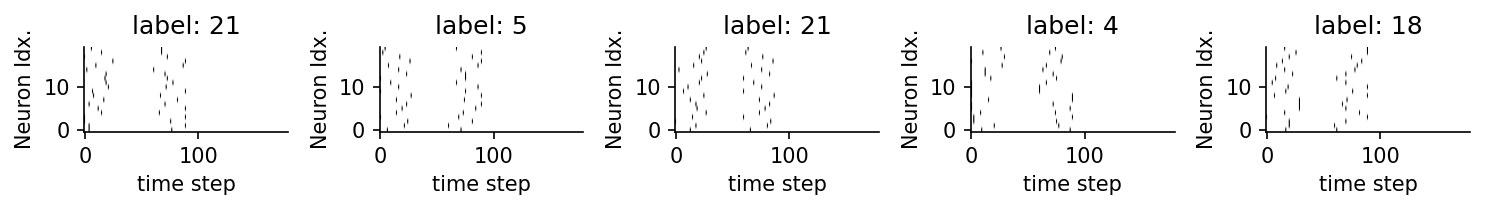

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [9]:
act_fn = stork.activations.SuperSpike
act_fn.beta = beta
neuron_group = FilterLIFGroup

model = RecurrentSpikingModel(
    batch_size,
    nb_time_steps,
    nb_inputs,
    device,
    dtype)

Add neuron groups

In [10]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(FilterLIFGroup(
    nb_hidden_units,
    nb_groups=8,
    tau_mem=tau_mem,
    tau_filter=tau_syn,
    activation=act_fn))
readout_group = model.add_group(ReadoutGroup(
    nb_classes,
    tau_mem=tau_readout,
    tau_syn=tau_syn,
    initial_state=-1e-2))



Add synapses between the neuron groups

In [11]:
con = model.add_connection(Connection(input_group, hidden_neurons))
con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [12]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = 4       # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(upperBoundL2Strength,threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

Add monitors for spikes and membrane potential

In [13]:
model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1]))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [14]:
loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [15]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [16]:
model.configure(input=input_group,
                output=readout_group,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=lr),
                time_step=dt)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [17]:
sigma_u = 1.0
nu = nb_spikes/duration

initializer = DistInitializer(
    dist = torch.distributions.Normal(0, 10),
    scaling='1/sqrt(k)'
)

con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Before we train the model, we monitor the spikes

In [18]:
print(nb_inputs*nb_hidden_units)

2560


In [19]:
# Monitors spike counts before training
res = model.monitor(ds_test)
total_spikes = torch.sum(res[0]).item()

results = {}
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(1)]
results["avg_layer_freq_init"] = [nb/len(ds_test)/duration/nb_hidden_units for nb in total_spikes_per_layer]

print(results)

{'avg_layer_freq_init': [10.817187500000001]}


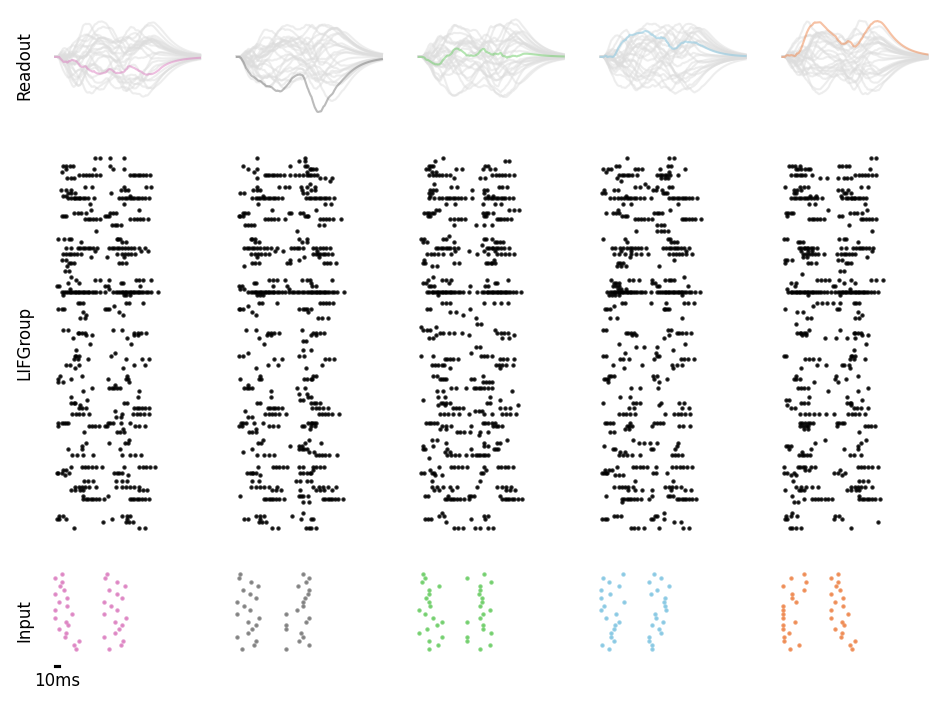

In [20]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=ds_test,
    point_alpha=0.8,
    show_predictions=False)

## Training

takes around 13-20 minutes

In [21]:
history = model.fit_validate(
    ds_train,
    ds_valid,
    nb_epochs=nb_epochs,
    verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

/home/gygajuli/miniconda3/envs/delay/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


00  loss=4.94 reg_loss=0.000147 acc=0.0249 -- val_loss=4.77 val_reg_loss=0.000128 val_acc=0.028 t_iter=6.40
01  loss=4.63 reg_loss=9.85e-05 acc=0.0283 -- val_loss=4.55 val_reg_loss=6.97e-05 val_acc=0.028 t_iter=5.30
02  loss=4.36 reg_loss=4.82e-05 acc=0.0451 -- val_loss=4.37 val_reg_loss=4.08e-05 val_acc=0.04 t_iter=5.31
03  loss=4.17 reg_loss=3.54e-05 acc=0.0357 -- val_loss=4.21 val_reg_loss=3.42e-05 val_acc=0.036 t_iter=5.21
04  loss=4.02 reg_loss=3.3e-05 acc=0.032 -- val_loss=4.04 val_reg_loss=3.03e-05 val_acc=0.032 t_iter=5.20
05  loss=3.83 reg_loss=3.1e-05 acc=0.0409 -- val_loss=3.92 val_reg_loss=3.01e-05 val_acc=0.052 t_iter=5.23
06  loss=3.72 reg_loss=3.03e-05 acc=0.0446 -- val_loss=3.81 val_reg_loss=3.01e-05 val_acc=0.048 t_iter=5.30
07  loss=3.66 reg_loss=3.02e-05 acc=0.0526 -- val_loss=3.74 val_reg_loss=3.03e-05 val_acc=0.056 t_iter=5.19
08  loss=3.62 reg_loss=3.03e-05 acc=0.0463 -- val_loss=3.67 val_reg_loss=3.02e-05 val_acc=0.076 t_iter=5.32
09  loss=3.47 reg_loss=3.02e-05 

#### Monitor the model again after training

In [22]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(1)]
results["avg_layer_freq"] = [nb/len(ds_test)/duration/nb_hidden_units for nb in total_spikes_per_layer]


## Test

In [23]:
scores = model.evaluate(ds_test).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  3.5001449584960938
Test acc.:  4.0 %


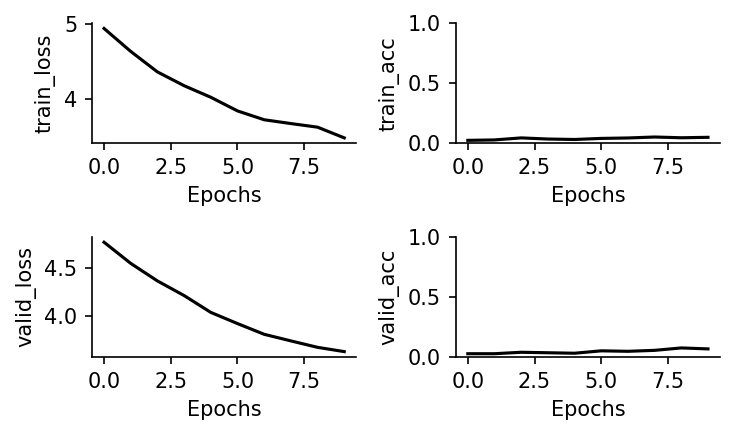

In [24]:
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i-2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", round(results["test_acc"]*100, 2), "%")

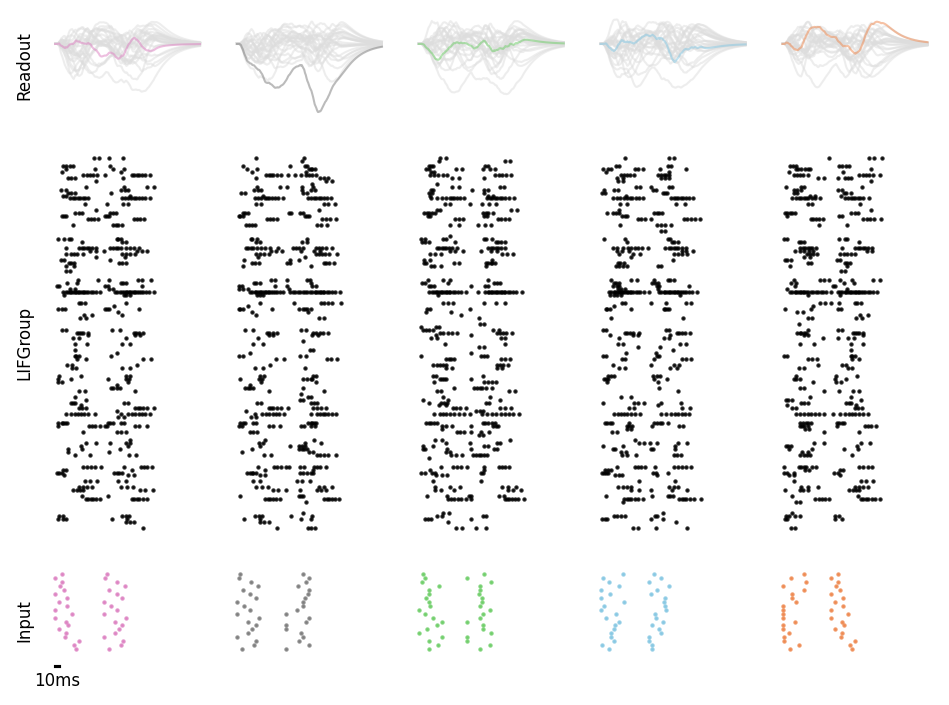

In [25]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=ds_test,
    point_alpha=0.8,
    show_predictions=False,
    nb_samples=5)